# Traffic Accidents analysis

## Dataset summary

The dataset to use in this exercise is "US Accidents (2016 - 2023)" by Sobhan Moosavi, which can be downloaded from Kaggle using this URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents.

This dataset contains information about traffic accidents in the United States from 2016 to 2023. It includes various features such as the date and time of the accident, location, weather conditions, and more.

In [1]:
import os

import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, weekday

C:\Users\danie\anaconda3\envs\env_pyspark\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloading the dataset

We can leverage the kagglehub package to download the dataset directly from Kaggle. This package allows us to download datasets without needing to manually download them from the Kaggle website.

In [2]:
# Download the latest version
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\danie\.cache\kagglehub\datasets\sobhanmoosavi\us-accidents\versions\13


If you have already downloaded the dataset to your local machine, you can set the path to the dataset instead of using the kagglehub package. Uncomment the following line and set the path to your local dataset.

In [3]:
# path = "your-local-path"

This dataset contains a single CSV file named `US_Accidents_March23.csv`. This file contains the data we will be working with in this exercise. Update the path variable to point to this file.

In [4]:
dataset_path = path + "/US_Accidents_March23.csv"
print(f"Filesize of the dataset: {os.path.getsize(dataset_path) / (1024 * 1024 * 1024):.2f} GB")

Filesize of the dataset: 2.85 GB


## Loading the dataset with PySpark

The first thing we need to do is to create a PySpark session.

In [5]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("USTrafficAccidents") \
    .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

spark

We can now simply load the dataset into a PySpark dataframe:

In [6]:
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

# Show the first 5 rows of the DataFrame
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

## Exploring the dataset

Now that the dataset is loaded, we can explore its contents. We can start by checking the schema of the DataFrame to understand the data types of each column.

In [7]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

We can also apply simple queries to get a better understanding of the data. For example, we can find the weather conditions with the most accidents.

In [8]:
df.groupBy("Weather_Condition") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(10, False)

+-----------------+-------+
|Weather_Condition|count  |
+-----------------+-------+
|Fair             |2560802|
|Mostly Cloudy    |1016195|
|Cloudy           |817082 |
|Clear            |808743 |
|Partly Cloudy    |698972 |
|Overcast         |382866 |
|Light Rain       |352957 |
|Scattered Clouds |204829 |
|NULL             |173459 |
|Light Snow       |128680 |
+-----------------+-------+
only showing top 10 rows



We can also do some basic data visualization. For example, we can plot a histogram with the number of accidents per time of day. For this, we extract the hour from the `Start_Time` column and group the data by hour. To make this easier, we execute the query using PySpark and convert the result to a Pandas DataFrame

In [9]:
by_hour = df.select(hour("Start_Time").alias("Hour")) \
    .groupBy("Hour") \
    .count() \
    .orderBy("Hour") \
    .toPandas()

by_hour

,Hour,count
0,0,112378
1,1,97071
2,2,93226
3,3,83864
4,4,159852
5,5,228182
6,6,405837
7,7,587472
8,8,577576
9,9,363034


<Axes: xlabel='Hour', ylabel='count'>

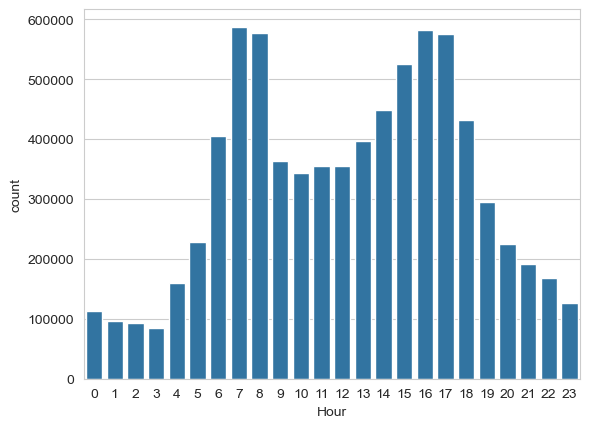

In [10]:
sns.barplot(data=by_hour, x="Hour", y="count")

We can even go further. For example, we can compare the number of accidents on weekdays and weekends. To do this, we can extract the weekday from the `Start_Time` column and group the data by weekday and hour.

In [11]:
by_day_hour = df.select(
    weekday("Start_Time").alias("Weekday"),
    hour("Start_Time").alias("Hour")) \
    .groupBy("Weekday", "Hour") \
    .count() \
    .orderBy("Weekday", "Hour") \
    .toPandas()

by_day_hour

,Weekday,Hour,count
0,0,0,13895
1,0,1,11676
2,0,2,11397
3,0,3,11316
4,0,4,26924
...,...,...,...
163,6,19,26534
164,6,20,23975
165,6,21,22922
166,6,22,19137


In [12]:
# Weekdays 5 and 6 are Saturday and Sunday, respectively
by_hour_workdays = by_day_hour.loc[by_day_hour["Weekday"] < 5] \
    .groupby("Hour") \
    .sum()

by_hour_weekends = by_day_hour.loc[by_day_hour["Weekday"] >= 5] \
    .groupby("Hour") \
    .sum()

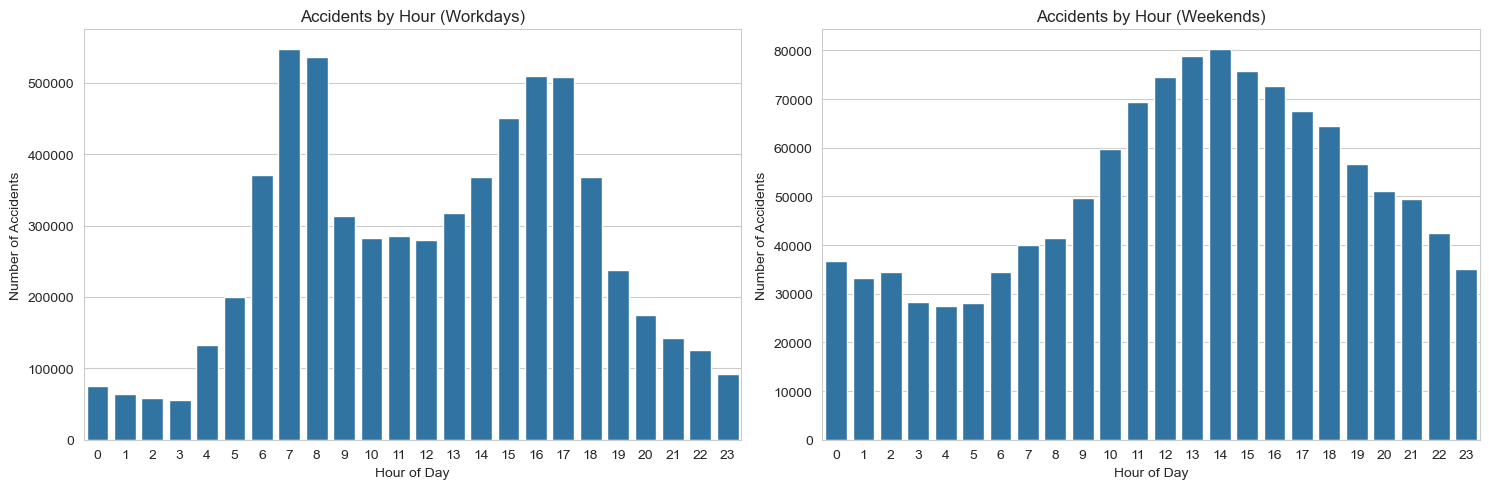

In [13]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot workdays
sns.barplot(data=by_hour_workdays, x="Hour", y="count", ax=ax1)
ax1.set_title("Accidents by Hour (Workdays)")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Number of Accidents")

# Plot weekends
sns.barplot(data=by_hour_weekends, x="Hour", y="count", ax=ax2)
ax2.set_title("Accidents by Hour (Weekends)")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Number of Accidents")

# Adjust layout to prevent overlap
plt.tight_layout()

In [14]:
from pyspark.sql.functions import col, sum as _sum

def contar_nulos_por_columna(df):
    """
    Cuenta los valores nulos en cada columna de un DataFrame de PySpark.

    Parámetros:
    df (pyspark.sql.DataFrame): El DataFrame que deseas analizar.

    Retorna:
    pyspark.sql.DataFrame: Un DataFrame con dos columnas: 'columna' y 'nulos'.
    """
    return df.select([
        _sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
    ]).toDF(*[f"{c}_nulos" for c in df.columns])

In [ ]:
# Supongamos que tienes un DataFrame llamado df:
nulos_df = contar_nulos_por_columna(df)
nulos_df.show()

In [16]:
from pyspark.sql.functions import col, sum, when

# Para cada columna, sumamos 1 cuando el valor es nulo, y 0 en caso contrario
null_counts = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])

null_counts.show()

+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twil

In [19]:
from pyspark.sql.functions import col, sum as _sum, lit
from pyspark.sql import Row

def contar_nulos_por_columna(df):
    """
    Cuenta los valores nulos en cada columna de un DataFrame de PySpark,
    muestra el resultado en formato vertical y filtra solo columnas con nulos.
    """
    # Contar nulos por columna
    nulos = df.select([
        _sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
    ]).collect()[0].asDict()

    # Crear una lista de Row solo con columnas que tengan nulos > 0
    columnas_con_nulos = [Row(columna=col_name, nulos=count) for col_name, count in nulos.items() if count > 0]

    # Convertir la lista a un DataFrame
    return df.sparkSession.createDataFrame(columnas_con_nulos)

In [20]:
nulos_df = contar_nulos_por_columna(df)
nulos_df.show()

+-----------------+-------+
|          columna|  nulos|
+-----------------+-------+
|          End_Lat|3402762|
|          End_Lng|3402762|
|      Description|      5|
|           Street|  10869|
|             City|    253|
|          Zipcode|   1915|
|         Timezone|   7808|
|     Airport_Code|  22635|
|Weather_Timestamp| 120228|
|   Temperature(F)| 163853|
|    Wind_Chill(F)|1999019|
|      Humidity(%)| 174144|
|     Pressure(in)| 140679|
|   Visibility(mi)| 177098|
|   Wind_Direction| 175206|
|  Wind_Speed(mph)| 571233|
|Precipitation(in)|2203586|
|Weather_Condition| 173459|
|   Sunrise_Sunset|  23246|
|   Civil_Twilight|  23246|
+-----------------+-------+
only showing top 20 rows



# References

- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.